In [1]:
import sqlite3
import pickle
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sparse_dot_topn import sp_matmul_topn
from sklearn.model_selection import train_test_split

In [2]:
# Define the database folder path and file names
db_folder = '../../data/processed_data/yelp_data/'
db_files = ['yelp_business_data.db', 'yelp_review_data.db']
db_paths = [db_folder + db_file for db_file in db_files]

In [3]:
# Connect to the databases and load data
def load_data_from_db():
    data = {}
    
    # Open connections and read tables
    conns = [sqlite3.connect(db_path) for db_path in db_paths]
    try:
        # Load tables from the databases
        data['business'] = pd.read_sql_query("SELECT * FROM business_details", conns[0])
        data['categories'] = pd.read_sql_query("SELECT * FROM business_categories", conns[0])
        data['review'] = pd.read_sql_query("SELECT * FROM review_data", conns[1])
    finally:
        # Close all database connections
        for conn in conns:
            conn.close()
    return data

In [4]:
# Load data into a dictionary
yelp_data = load_data_from_db()

# Check loaded data
for table, df in yelp_data.items():
    print(f"Loaded {len(df)} rows from {table} table.")

Loaded 78059 rows from business table.
Loaded 360656 rows from categories table.
Loaded 980418 rows from review table.


In [5]:
df_business = yelp_data['business'] # Business details
df_categories = yelp_data['categories'] # Business categories
df_review = yelp_data['review'] # Review data


In [19]:
print(df_business.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'hours'],
      dtype='object')


In [20]:
print(df_categories.columns)

Index(['business_id', 'category'], dtype='object')


In [21]:
print(df_review.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')


In [14]:
display(df_business.head(10))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours
0,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,UJsufbvfyfONHeWdvAHKjA,Marshalls,21705 Village Lakes Sc Dr,Land O' Lakes,FL,34639,28.190459,-82.457380,3.5,6,1,"{'RestaurantsPriceRange2': '2', 'BikeParking':...","{'Monday': '9:30-21:30', 'Tuesday': '9:30-21:3..."
3,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
5,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
6,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
7,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,Edmonton,AB,T5J 1B9,53.546045,-113.499169,4.0,40,0,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
8,qhDdDeI3K4jy2KyzwFN53w,Barnes & Noble Booksellers,8675 River Crossing Blvd,Indianapolis,IN,46240,39.913820,-86.105739,4.0,38,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
9,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,IN,46250,39.904320,-86.053080,4.0,20,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [11]:
display(df_categories.head(10))

,business_id,category
0,tUFrWirKiKi_TAnsVWINQQ,Department Stores
1,tUFrWirKiKi_TAnsVWINQQ,Shopping
2,tUFrWirKiKi_TAnsVWINQQ,Fashion
3,tUFrWirKiKi_TAnsVWINQQ,Home & Garden
4,tUFrWirKiKi_TAnsVWINQQ,Electronics
5,tUFrWirKiKi_TAnsVWINQQ,Furniture Stores
6,MTSW4McQd7CbVtyjqoe9mw,Restaurants
7,MTSW4McQd7CbVtyjqoe9mw,Food
8,MTSW4McQd7CbVtyjqoe9mw,Bubble Tea
9,MTSW4McQd7CbVtyjqoe9mw,Coffee & Tea


In [12]:
display(df_review.head(10))

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,f1MJKwk8Nk2MNxns6-tvfg,BDwy_2vFLT2urUhvNrKDLQ,8yR12PNSMo6FBYx1u5KPlw,4.0,2020-01-21 16:10:04,"I know this is a burger spot, but I loooove th...",1,0,0
1,pixVBYRdOuSPoeCSzXYVEg,s8jr65E_xPSW84nh6CG94w,hyFzDuyOWNG2rg5GYJ2wiQ,4.0,2019-04-21 02:44:33,Make a reservation! It's a cute and small spac...,2,0,0
2,yCtvsHB7_TsQ90xt-cXh4Q,uBHAc_FrPUd_1eZZgUrYMw,QU0tsRJw8vabl_tYkN2vqw,5.0,2017-06-04 22:21:07,The revamped theaters look amazing. Love the r...,1,0,0
3,QIJ1WG42Cgbnr3GudPjNmg,DBpcvcKAYaf_JLH4gp_EZA,-1MhPXk1FglglUAmuPLIGg,3.0,2009-08-03 00:02:04,The philly cheese steak was very good and the ...,1,0,1
4,okYXLbzrcRrrcqkaboS6Jw,xxTbaKNocxzsYyUoyxnELA,yPSejq3_erxo9zdVYTBnZA,5.0,2018-05-08 01:59:31,Best Mexican place in Santa Barbara County. I'...,1,0,0
5,t7PnWELe4SmS8aO4TF8jbQ,Z1uqZ9mtOeb-0Dd9jQQ_jA,TmOSBESpzQC0HeRGXZzAbw,2.0,2011-04-17 03:29:57,Question? \nHow does a business survive sellin...,2,0,0
6,F2oSHnuRHhutYtrAHkY5AQ,drui1iMt-TPzJiSkQp5CtA,of8rPgDiF6tohcH1JVPA1g,5.0,2010-12-11 19:40:50,"A couple of weeks ago, my car got side swiped ...",7,1,1
7,lVHvXysgKgBm_3eSZNEjNg,Q4bwPyE9Z-KeKd6BfLXeVA,FbTlPul0byYrG953tRCaXA,4.0,2014-01-11 14:27:01,Had to try it since we saw the new Triple D ep...,0,0,0
8,7CBSsyWThdwgp0qcmN0Ddw,4QoinbcwOxt-Mvc1sAtBKg,oqbhVgliVJH-iRa3AnD-3A,3.0,2022-01-03 20:04:31,Chai latte - a little spicier than other chai ...,0,0,0
9,rjrfVyAEgNRhsaQD0Zy6xQ,_kaShYTfBuDaeQTth_WU1g,9Q_dbzylYiWdF11lH8uaSg,5.0,2013-11-02 14:04:59,I gave Sulimay's five stars because it is perf...,2,1,2


In [31]:
df_review["stars"].describe()

count    980418.000000
mean          3.843513
std           1.284335
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64

In [22]:
# 1. Popularity-Quality Interaction
# For each business: Interaction = review_count * stars
df_business['popularity_quality'] = df_business['review_count'] * df_business['stars']

# 2. Log-Transform on Review Counts
# Apply log1p to handle zero counts gracefully (log1p(x) = log(1 + x))
df_business['log_review_count'] = np.log1p(df_business['review_count'])

# 3. Recency of Review
# Convert 'date' to datetime and compute the difference from today in days
df_review['date'] = pd.to_datetime(df_review['date'])
current_date = pd.Timestamp.today()
df_review['recency_days'] = (current_date - df_review['date']).dt.days


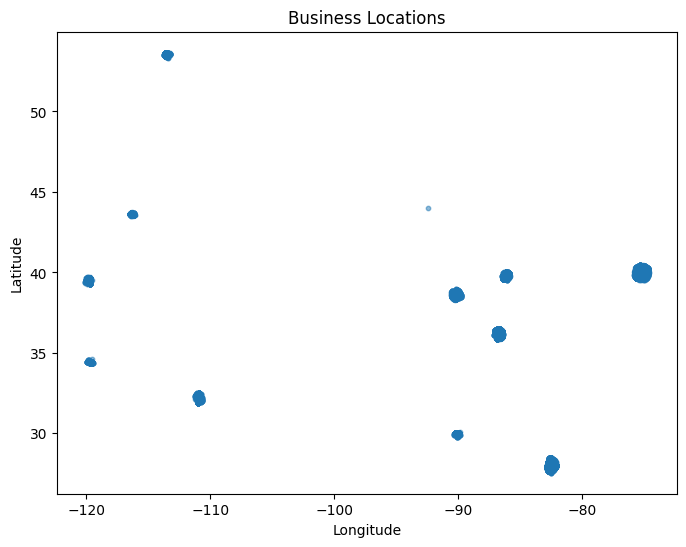

Cluster Centers (latitude, longitude):
[[  28.55436194  -84.77248312]
 [  41.81756458 -117.86310404]
 [  39.17113688  -80.94046778]
 [  32.24907522 -110.93376408]]


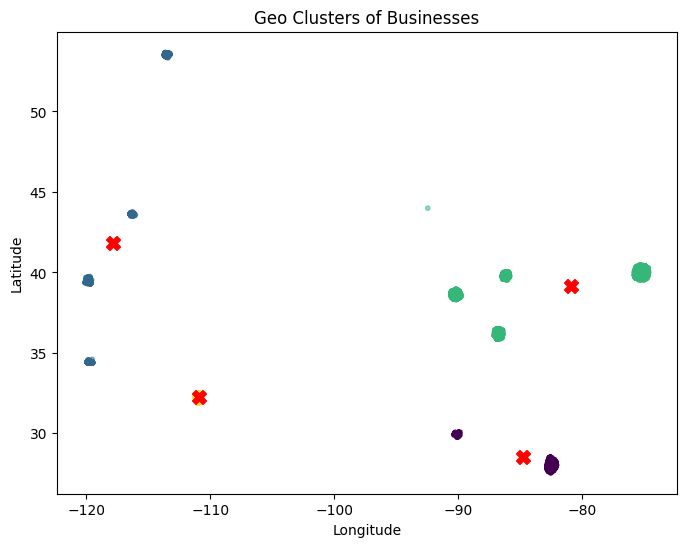

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume you have already loaded your business dataframe as df_business
# with columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
# 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'hours']

# Extract the geographic coordinates
coords = df_business[['latitude', 'longitude']]

# Optional: Plot the locations to visually inspect distribution
plt.figure(figsize=(8, 6))
plt.scatter(coords['longitude'], coords['latitude'], alpha=0.5, s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Business Locations")
plt.show()

# Define number of clusters, for example k=10. You could also use the elbow method to choose k.
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_business['geo_cluster'] = kmeans.fit_predict(coords)

# Inspect cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers (latitude, longitude):")
print(cluster_centers)

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(coords['longitude'], coords['latitude'], c=df_business['geo_cluster'], cmap='viridis', alpha=0.5, s=10)
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c='red', marker='X', s=100)  # Note: longitude is x, latitude is y.
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geo Clusters of Businesses")
plt.show()


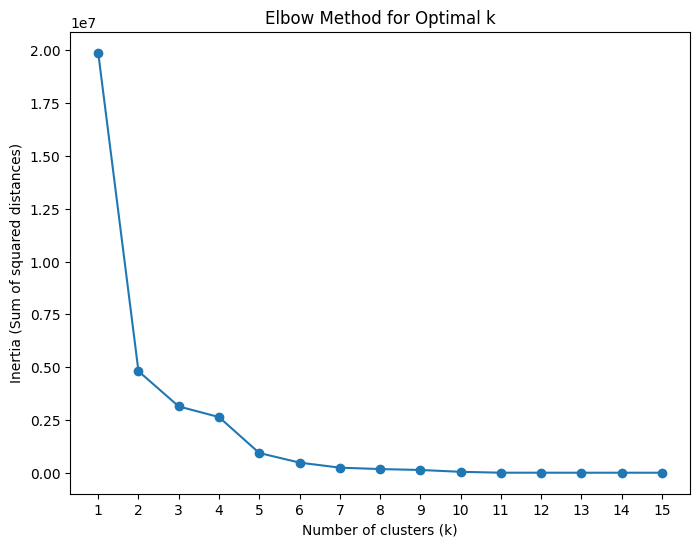

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assume df_business is already loaded and has 'latitude' and 'longitude'
coords = df_business[['latitude', 'longitude']]

# Define a range of k values to test, for example 1 to 15 clusters
k_range = range(1, 16)
inertias = []

# Compute inertia for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of squared distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_range)
plt.show()


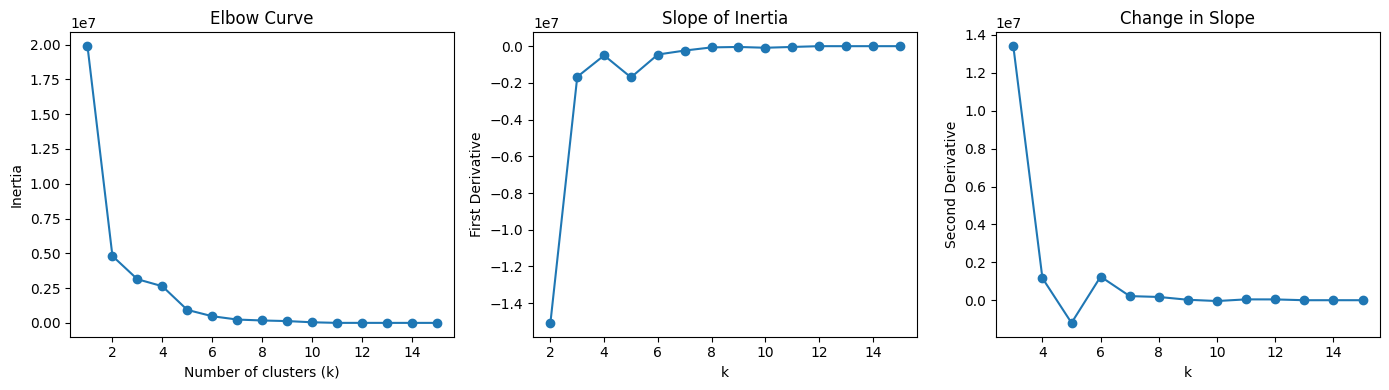

Optimal k (using slope analysis): 4


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assume df_business is already loaded and contains 'latitude' and 'longitude'
coords = df_business[['latitude', 'longitude']]

# Compute inertia for a range of k values (e.g., 1 to 15)
k_range = range(1, 16)
inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

# Convert inertias to a NumPy array for easier calculations
inertias = np.array(inertias)

# Calculate the first derivative (difference between consecutive inertias)
first_deriv = np.diff(inertias)  # len = len(k_range) - 1

# Calculate the second derivative (difference between consecutive first derivatives)
second_deriv = np.diff(first_deriv)  # len = len(k_range) - 2

# Plot the inertia curve and its derivatives
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve")

plt.subplot(1, 3, 2)
plt.plot(list(k_range)[1:], first_deriv, marker='o')
plt.xlabel("k")
plt.ylabel("First Derivative")
plt.title("Slope of Inertia")

plt.subplot(1, 3, 3)
plt.plot(list(k_range)[2:], second_deriv, marker='o')
plt.xlabel("k")
plt.ylabel("Second Derivative")
plt.title("Change in Slope")

plt.tight_layout()
plt.show()

# One approach: choose the k where the second derivative is minimized
# Note: second_deriv[0] corresponds to k=3, so we add 2 to the index.
optimal_k = np.argmin(second_deriv) + 2
print("Optimal k (using slope analysis):", optimal_k)


  geo_group  count
0     9q4ey      1
1     9q4ez     17
2     9q4g8      1
3     9q4gb    262
4     9q4gc    344


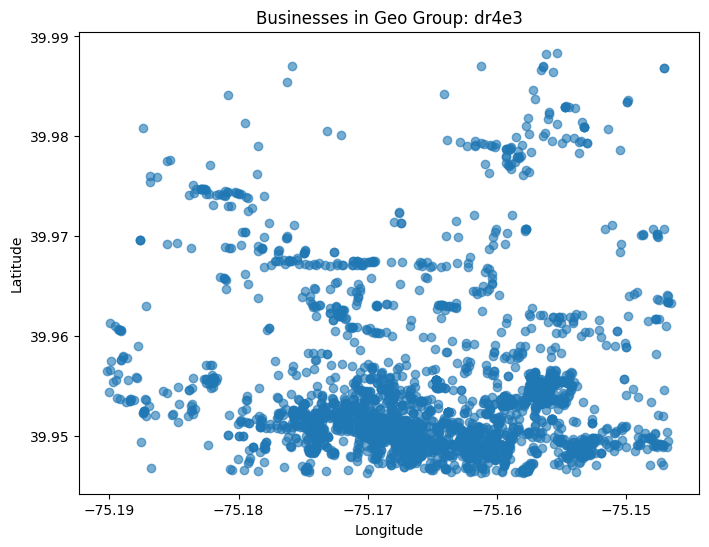

In [33]:
import pandas as pd
import pygeohash as pgh

# Example: suppose df_business is your DataFrame
# Let's create a new column 'geohash' with a precision level of 7 (you can adjust precision)
df_business['geohash'] = df_business.apply(
    lambda row: pgh.encode(row['latitude'], row['longitude'], precision=7), axis=1
)

# Now, businesses with similar geohash prefixes are geographically close.
# For instance, you could group by the first 5 characters for a coarser grouping:
df_business['geo_group'] = df_business['geohash'].str[:5]

# Example: Count businesses per geo_group
geo_group_counts = df_business.groupby('geo_group').size().reset_index(name='count')
print(geo_group_counts.head())

# Optionally, visualize one group:
import matplotlib.pyplot as plt

# Let's filter businesses in a specific geo_group
group = df_business[df_business['geo_group'] == df_business['geo_group'].iloc[1]]
plt.figure(figsize=(8,6))
plt.scatter(group['longitude'], group['latitude'], alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Businesses in Geo Group: {group['geo_group'].iloc[0]}")
plt.show()
